In [11]:
# FAZENDO IMPORTS
# ok

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
#  CARREGANDO BASE DE DADOS

#drive.mount('/content/drive')
#data = pd.read_csv('/content/drive/MyDrive/Machine Learning Project/Deep_Learning/Final_Grads_SJCU.csv')
#data_tensor = torch.FloatTensor(data.values)

In [3]:
#   CONTROLE DE ALEATORIEDADE
# ok

seed = 42
np.random.seed(seed)

In [4]:
#  GERANDO UM MOCK DATASET
# ok

# Define the number of samples
num_samples = 200

# Generate random features
features = pd.DataFrame(np.random.randn(num_samples, 3), columns=['feature1', 'feature2', 'feature3'])

# Generate target values based on some rules
target = 100 * (features['feature1'].rolling(window=4, min_periods=1).sum() + features['feature2'].rolling(window=3, min_periods=1).sum() - features['feature3'].rolling(window=2, min_periods=1).sum())

# Normalize features only (excluding the target column)
features_normalized = (features - features.mean()) / features.std()

# Combine normalized features with the original target column
data_normalized = pd.concat([features_normalized, pd.DataFrame({'target': target})], axis=1)



# Convert to PyTorch tensor
data_tensor = torch.FloatTensor(data_normalized.values)
print(data_tensor)

tensor([[ 4.8608e-01,  8.6028e-03,  6.0009e-01, -2.8924e+01],
        [ 1.6349e+00, -8.6932e-02, -2.7629e-01,  1.2338e+02],
        [ 1.6978e+00,  9.1096e-01, -5.1018e-01,  4.6976e+02],
        [ 5.3740e-01, -3.1535e-01, -5.0646e-01,  5.1466e+02],
        [ 2.0092e-01, -1.7599e+00, -1.7579e+00,  4.4681e+02],
        [-6.9933e-01, -8.6274e-01,  2.6871e-01, -1.7741e+01],
        [-1.0863e+00, -1.2607e+00,  1.4130e+00, -6.8041e+02],
        [-3.2265e-01,  2.1364e-01, -1.4596e+00, -3.8526e+02],
        [-6.7929e-01,  2.5687e-01, -1.1875e+00, -8.9858e+01],
        [ 3.5062e-01, -4.5206e-01, -3.3349e-01, -2.8199e+01],
        [-7.4346e-01,  1.9918e+00, -5.7016e-02,  6.7159e+01],
        [-1.2539e+00,  9.6587e-01, -1.2569e+00,  1.4804e+02],
        [ 1.6387e-01, -1.8061e+00, -1.3636e+00,  2.1893e+02],
        [ 1.5044e-01,  8.8210e-01,  1.2671e-01, -4.9553e+01],
        [-1.9938e-01, -1.5364e-01, -1.5130e+00, -9.8279e+01],
        [-8.7570e-01, -3.1258e-01,  1.0070e+00, -3.1644e+00],
        

In [5]:
#   ALINHA OS DADOS DE FORMA SEQUENCIAL
# ok

def create_inout_sequences(input_data, seq_length):
    inout_seq = []
    L = len(input_data)
    for i in range(L - seq_length):
        seq = input_data[i:i + seq_length, :3]  # first 3 columns as input
        label = input_data[i + seq_length, 3:]  # last columns as target
        inout_seq.append((seq, label))
    return inout_seq

def get_list_shape(lst):
    shape = []
    while isinstance(lst, list):
        shape.append(len(lst))
        lst = lst[0] if lst else []
    return tuple(shape)

seq_length = 3 # Number of samples that will influence the last one
inout_seq = create_inout_sequences(data_tensor, seq_length)

train_data = inout_seq[:int(0.8 * len(inout_seq))]
test_data = inout_seq[int(0.8 * len(inout_seq)):]

In [6]:
def check_data(data):
    for seq, labels in data:
        if torch.isnan(seq).any() or torch.isinf(seq).any():
            print("NaN or Inf detected in sequence data")
        if torch.isnan(labels).any() or torch.isinf(labels).any():
            print("NaN or Inf detected in label data")

check_data(train_data)

In [7]:
#   CRIA MODELO PARA RNN
# ok

class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True) #RNN Layer
        self.fc = nn.Linear(hidden_size, output_size) # Fully connected Layer

    def forward(self, x):
        batch_size = x.size(0)
        hidden = torch.zeros(self.n_layers ,batch_size, self.hidden_size).to(x.device)
        out, hidden = self.rnn(x, hidden)
        #out = out.contiguous().view(-1, self.hidden_size)
        #out = self.fc(out)
        out = self.fc(out[:, -1, :])
        return out, hidden

In [8]:
#   TREINA RNN
# erro no treinamento, funções de perda gerando NaN

def train_model(model, train_data, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for seq, labels in train_data:
            optimizer.zero_grad()
            seq = torch.FloatTensor(seq)  # Convert to PyTorch tensor
            seq = seq.unsqueeze(0)
            labels = torch.FloatTensor(labels)  # Convert to PyTorch tensor
            labels = labels.unsqueeze(0)
            y_pred, hidden = model(seq)
            loss = criterion(y_pred, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
            optimizer.step()
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')
    return model

input_size = 3
hidden_size = 60
output_size = 1
n_layers = 1
num_epochs = 500
learning_rate = 0.002

model = VanillaRNN(input_size, hidden_size, output_size, n_layers)
model = train_model(model, train_data, num_epochs, learning_rate)

Epoch 5/500, Loss: 8221.265625
Epoch 10/500, Loss: 4803.611328125
Epoch 15/500, Loss: 1708.140625
Epoch 20/500, Loss: 663.8560180664062
Epoch 25/500, Loss: 120.40789031982422
Epoch 30/500, Loss: 9.853655815124512
Epoch 35/500, Loss: 396.2879638671875
Epoch 40/500, Loss: 99.76637268066406
Epoch 45/500, Loss: 3.3871309757232666
Epoch 50/500, Loss: 235.9467315673828
Epoch 55/500, Loss: 46.594329833984375
Epoch 60/500, Loss: 144.77723693847656
Epoch 65/500, Loss: 519.5322875976562
Epoch 70/500, Loss: 216.52618408203125
Epoch 75/500, Loss: 46.61474609375
Epoch 80/500, Loss: 62.255340576171875
Epoch 85/500, Loss: 257.3876037597656
Epoch 90/500, Loss: 215.88897705078125
Epoch 95/500, Loss: 82.282470703125
Epoch 100/500, Loss: 90.74832916259766
Epoch 105/500, Loss: 232.54737854003906
Epoch 110/500, Loss: 9.005768775939941
Epoch 115/500, Loss: 408.6528625488281
Epoch 120/500, Loss: 485.7734069824219
Epoch 125/500, Loss: 161.35853576660156
Epoch 130/500, Loss: 10.073184967041016
Epoch 135/500, L

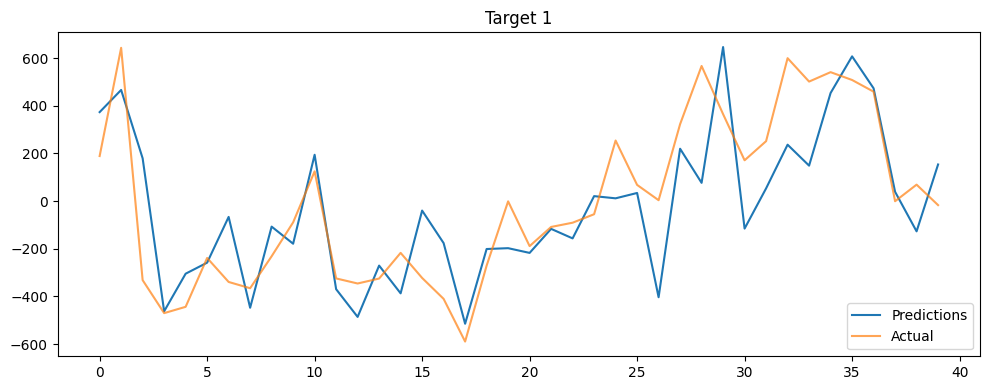

In [9]:
#   AVALIA E EXIBE OS RESULTADOS
# ok

def evaluate_model(model, test_data):
    model.eval()
    predictions = []
    with torch.no_grad():
        for seq, _ in test_data:
            seq = seq.view(1, -1, 3)  # reshape to (batch_size, seq_length, num_features)
            y_pred, hidden = model(seq)
            last_time_steo_output = y_pred[-1, :]
            predictions.append(last_time_steo_output.squeeze().cpu().numpy())
    return predictions

predictions = evaluate_model(model, test_data)
predictions = np.array(predictions)

test_targets = [label.numpy() for _, label in test_data]
test_targets = np.array(test_targets)

num_samples = len(predictions)
num_targets = 1

for i in range(num_targets):
    plt.figure(figsize=(10, 4))
    plt.plot(predictions[:], label='Predictions')
    plt.plot(test_targets[:], label='Actual', alpha=0.7)
    plt.title(f'Target {i + 1}')
    plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#   GERA MATRIX DE CONFUSÃO

def apply_rule(y_test, y_pred):
    new_test = np.where(y_test > 400, 1, 0)
    new_preds = np.where(y_pred > 400, 1, 0)
    return new_test, new_preds

true_labels, predicted_labels = apply_rule(test_targets, predictions)

# Calculate the accuracy
print('Accuracy:')
print(accuracy_score(true_labels, predicted_labels))

# Generate a classification report
print('Classification Report:')
print(classification_report(true_labels, predicted_labels))

# Print the cross-validation confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

Accuracy:
0.9
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        33
           1       0.80      0.57      0.67         7

    accuracy                           0.90        40
   macro avg       0.86      0.77      0.80        40
weighted avg       0.89      0.90      0.89        40

Confusion Matrix:
[[32  1]
 [ 3  4]]
